# Capstone Phase 2 - ANN  
Exploration of Artificial Neural Networks

### Import some libraries we'll need

In [ ]:
import joblib
import pandas as pd
import numpy as np
from sklearn import preprocessing
from zipfile import ZipFile

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Some Utility Stuff

In [ ]:
def transform_data(df):
    no_labels = df.drop(['label', 'attack_cat'], axis=1)
    one_hot = pd.get_dummies(no_labels, columns=['proto', 'service', 'state'], prefix=['proto', 'service', 'state'])
    scaler = preprocessing.StandardScaler().fit(one_hot)
    standardized = scaler.transform(one_hot)
    std = pd.DataFrame(standardized, columns=one_hot.columns)

    labels = df['label'].copy()
    cats = df['attack_cat'].copy()
    
    return std, labels, cats

In [ ]:
def plt_norm_confmat(model, X, y, title, fname=None, labels=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    display = plot_confusion_matrix(model, X, y, display_labels=labels, cmap=plt.cm.Blues, 
                                    normalize='true', xticks_rotation='vertical', ax=ax)
    display.ax_.set_title(title)
    if fname is not None:
        file = './images/' + fname + '.png'
        plt.savefig(file, dpi=300, bbox_inches='tight')

In [ ]:
def gen_metrics(y_train, y_pred):
    conf_mat = confusion_matrix(y_train, y_pred)
    class_rep = classification_report(y_train, y_pred, zero_division=0)
    rep_dict = classification_report(y_train, y_pred, zero_division=0, output_dict=True)
    acc = accuracy_score(y_train, y_pred)
    return conf_mat, class_rep, rep_dict, acc

### Load data and apply transformations

We need to upload the data file from our local drive.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving UNSW_NB15 training and testing sets.zip to UNSW_NB15 training and testing sets.zip


Import the io library so we can load the file we uploaded.

In [ ]:
import io

In [ ]:
with ZipFile(io.BytesIO(uploaded['UNSW_NB15 training and testing sets.zip'])) as datasets_zip:
    # open each file and read in to a DataFrame
    with datasets_zip.open('UNSW_NB15_training-set.csv') as training_file:
        training_data = pd.read_csv(training_file, index_col='id')
    with datasets_zip.open('UNSW_NB15_testing-set.csv') as testing_file:
        testing_data = pd.read_csv(testing_file, index_col='id')

In [ ]:
training_data_std, training_labels, training_cats = transform_data(training_data)
testing_data_std, testing_labels, testing_cats = transform_data(testing_data)

In [ ]:
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(training_cats)
y_test = label_encoder.fit_transform(testing_cats)

In [ ]:
class_names = list(label_encoder.classes_)

### Load feature subsets

First upload the file from our local drive

In [ ]:
features_pkl = files.upload() # joblib.load('./data/feature_subsets.pkl')

Saving feature_subsets.pkl to feature_subsets.pkl


In [ ]:
feature_subsets = joblib.load('feature_subsets.pkl')

In [ ]:
train_std_ig = training_data_std[feature_subsets['ig']].copy()
test_std_ig = testing_data_std[feature_subsets['ig']].copy()

train_std_anova = training_data_std[feature_subsets['anova']].copy()
test_std_anova = testing_data_std[feature_subsets['anova']].copy()

train_std_vt = training_data_std[feature_subsets['vt']].copy()
test_std_vt = testing_data_std[feature_subsets['vt']].copy()

train_std_mad = training_data_std[feature_subsets['mad']].copy()
test_std_mad = testing_data_std[feature_subsets['mad']].copy()

train_std_corr = training_data_std[feature_subsets['corr']].copy()
test_std_corr = testing_data_std[feature_subsets['corr']].copy()

train_std_rfe = training_data_std[feature_subsets['rfe']].copy()
test_std_rfe = testing_data_std[feature_subsets['rfe']].copy()

### Artificial Neural Network  
We'll start with a basic sequential model.

In [ ]:
import tensorflow as tf
from tensorflow import keras

We're going to start with a basic Sequential network with following connected layers using ReLU activation.  Because we're doing multiclassification we'll use softmax activation on the output layer.  

A. Géron, “Chapter 10: Introduction to Artificial Neural Networks with Keras,” in Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: concepts, tools, and techniques to build intelligent systems, 2nd ed., Sebastopol, CA: O'Reilly Media, Inc., 2019, p. 299. 

In [ ]:
model = keras.models.Sequential([keras.layers.Input(shape=train_std_ig.shape[1:]),
                                 keras.layers.Dense(300, activation='relu'),
                                 keras.layers.Dense(100, activation='relu'),
                                 keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               6300      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 37,410
Trainable params: 37,410
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
hist = model.fit(train_std_ig, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
4384/4384 [==============================] - 7s 2ms/step - loss: 1.0658 - accuracy: 0.6178 - val_loss: 0.4872 - val_accuracy: 0.8502
Epoch 2/30
4384/4384 [==============================] - 7s 1ms/step - loss: 0.7711 - accuracy: 0.7162 - val_loss: 0.4433 - val_accuracy: 0.8625
Epoch 3/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.7256 - accuracy: 0.7350 - val_loss: 0.4182 - val_accuracy: 0.8731
Epoch 4/30
4384/4384 [==============================] - 7s 1ms/step - loss: 0.7006 - accuracy: 0.7401 - val_loss: 0.4113 - val_accuracy: 0.8746
Epoch 5/30
4384/4384 [==============================] - 7s 1ms/step - loss: 0.6897 - accuracy: 0.7437 - val_loss: 0.3910 - val_accuracy: 0.8776
Epoch 6/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.6684 - accuracy: 0.7481 - val_loss: 0.3770 - val_accuracy: 0.8843
Epoch 7/30
4384/4384 [==============================] - 7s 1ms/step - loss: 0.6623 - accuracy: 0.7480 - val_loss: 0.3716 - val_accuracy:

In [ ]:
import seaborn as sns

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

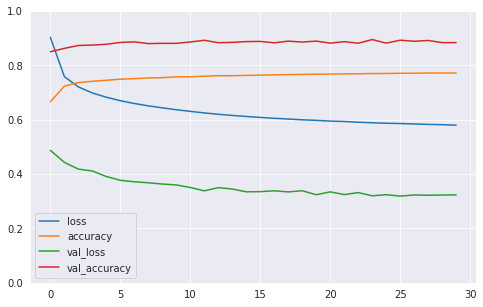

In [ ]:
pd.DataFrame(hist.history).plot(figsize=(8, 5))
sns.set_style('darkgrid')
plt.ylim((0, 1))
plt.savefig('ann-1-learning-curves.png', dpi=300, bbox_inches='tight')
files.download('ann-1-learning-curves.png')
plt.show()

In [ ]:
model.save('sequential1.h5')
files.download('sequential1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

These results look very good for a quick test.  But there is something strange going on, because the validation accuracy is higher than training, and validation loss is much lower than training.  This might be because the network is too large for the data set.  We used 2 layers with 300, and 100 nodes, but we only used 20 features from the data set.  We should try a smaller network for smaller feature sets.  
Of course we'll also want to tune the hyper-parameters.  The training set is skewed so we should set `class_weight`.  
For comparison to the other models we'll want to train on each feature subset, but ultimately we want to see what we can do with the full set.

Let's see what happens with fewer nodes.

In [ ]:
model2 = keras.models.Sequential([keras.layers.Input(shape=train_std_ig.shape[1:]),
                                 keras.layers.Dense(20, activation='relu'),
                                 keras.layers.Dense(15, activation='relu'),
                                 keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
hist2 = model2.fit(train_std_ig, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
4384/4384 [==============================] - 6s 1ms/step - loss: 1.1836 - accuracy: 0.5725 - val_loss: 0.5260 - val_accuracy: 0.8357
Epoch 2/30
4384/4384 [==============================] - 5s 1ms/step - loss: 0.8185 - accuracy: 0.6958 - val_loss: 0.4694 - val_accuracy: 0.8667
Epoch 3/30
4384/4384 [==============================] - 5s 1ms/step - loss: 0.7609 - accuracy: 0.7163 - val_loss: 0.4407 - val_accuracy: 0.8683
Epoch 4/30
4384/4384 [==============================] - 5s 1ms/step - loss: 0.7399 - accuracy: 0.7282 - val_loss: 0.4238 - val_accuracy: 0.8786
Epoch 5/30
4384/4384 [==============================] - 5s 1ms/step - loss: 0.7232 - accuracy: 0.7336 - val_loss: 0.4116 - val_accuracy: 0.8813
Epoch 6/30
4384/4384 [==============================] - 5s 1ms/step - loss: 0.7112 - accuracy: 0.7365 - val_loss: 0.4032 - val_accuracy: 0.8813
Epoch 7/30
4384/4384 [==============================] - 5s 1ms/step - loss: 0.7000 - accuracy: 0.7384 - val_loss: 0.3944 - val_accuracy:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

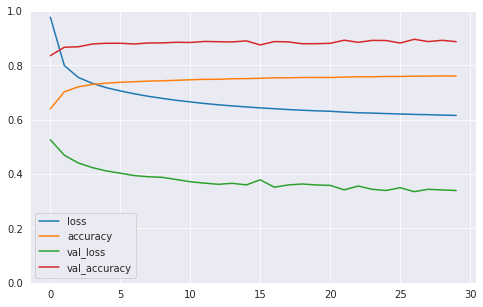

In [ ]:
pd.DataFrame(hist2.history).plot(figsize=(8, 5))
sns.set_style('darkgrid')
plt.ylim((0, 1))
plt.savefig('ann-2-learning-curves.png', dpi=300, bbox_inches='tight')
files.download('ann-2-learning-curves.png')
plt.show()

In [ ]:
model2.save('sequential2.h5')
files.download('sequential2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Even with far fewer nodes we still see the same behavior.  A little more investigation is called for.

The issue may be with the training/validation split.  The 20% `validation_split` may not be representative of the full data set.  It's probably better to use k-fold cross-validation.  That's also what we did for the other models we've trained.

In [ ]:
model3 = keras.models.Sequential([keras.layers.Input(shape=train_std_ig.shape[1:]),
                                 keras.layers.Dense(18, activation='relu'),
                                 keras.layers.Dense(15, activation='relu'),
                                 keras.layers.Dense(12, activation='relu'),
                                 keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
hist3 = model3.fit(train_std_ig, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
4384/4384 [==============================] - 8s 2ms/step - loss: 0.9935 - accuracy: 0.6500 - val_loss: 0.4117 - val_accuracy: 0.8798
Epoch 2/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.6939 - accuracy: 0.7386 - val_loss: 0.3862 - val_accuracy: 0.8829
Epoch 3/30
4384/4384 [==============================] - 7s 1ms/step - loss: 0.6630 - accuracy: 0.7489 - val_loss: 0.3652 - val_accuracy: 0.8835
Epoch 4/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.6416 - accuracy: 0.7535 - val_loss: 0.3522 - val_accuracy: 0.8838
Epoch 5/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.6300 - accuracy: 0.7562 - val_loss: 0.3404 - val_accuracy: 0.8861
Epoch 6/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.6219 - accuracy: 0.7606 - val_loss: 0.3388 - val_accuracy: 0.8888
Epoch 7/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.6197 - accuracy: 0.7617 - val_loss: 0.3405 - val_accuracy:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

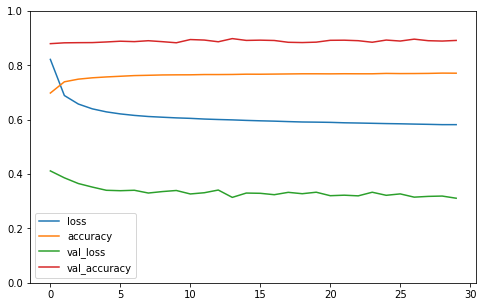

In [ ]:
pd.DataFrame(hist3.history).plot(figsize=(8, 5))
sns.set_style('darkgrid')
plt.ylim((0, 1))
plt.savefig('ann-3-learning-curves.png', dpi=300, bbox_inches='tight')
files.download('ann-3-learning-curves.png')
plt.show()

In [ ]:
model3.save('sequential3.h5')
files.download('sequential3.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Adding more layers and changing the optimizer to 'Adam' improves training accuracy and loss. Validation accuracy and loss remain about the same. Perhaps cross-validation will make a difference, but maybe we just need to tune the parameters.

Let's try one with a larger feature set.

In [ ]:
sorted_features_pkl = files.upload() # joblib.load('./data/rfb3_sorted_feature_importances.pkl')

Saving rfb3_sorted_feature_importances.pkl to rfb3_sorted_feature_importances.pkl


In [39]:
sorted_features = joblib.load('rfb3_sorted_feature_importances.pkl')

In [41]:
top_feats = [x[0] for x in sorted_features if x[1] > 1e-3]

In [42]:
train_std_RF = training_data_std[top_feats].copy()
test_std_RF = testing_data_std[top_feats].copy()

In [43]:
len(top_feats)

50

In [44]:
model4 = keras.models.Sequential([keras.layers.Input(shape=train_std_RF.shape[1:]),
                                 keras.layers.Dense(48, activation='relu'),
                                 keras.layers.Dense(36, activation='relu'),
                                 keras.layers.Dense(24, activation='relu'),
                                 keras.layers.Dense(12, activation='relu'),
                                 keras.layers.Dense(10, activation='softmax')
])

In [45]:
# we're using Sparse Categorical Cross-entropy loss b/c the labels are integers, not one-hot vectors
model4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
hist4 = model4.fit(train_std_RF, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
4384/4384 [==============================] - 8s 2ms/step - loss: 0.8139 - accuracy: 0.6976 - val_loss: 0.3138 - val_accuracy: 0.8962
Epoch 2/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.6051 - accuracy: 0.7584 - val_loss: 0.3072 - val_accuracy: 0.8964
Epoch 3/30
4384/4384 [==============================] - 8s 2ms/step - loss: 0.5791 - accuracy: 0.7665 - val_loss: 0.3017 - val_accuracy: 0.8919
Epoch 4/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.5680 - accuracy: 0.7716 - val_loss: 0.2902 - val_accuracy: 0.9041
Epoch 5/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.5615 - accuracy: 0.7748 - val_loss: 0.2826 - val_accuracy: 0.9047
Epoch 6/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.5561 - accuracy: 0.7742 - val_loss: 0.2965 - val_accuracy: 0.8906
Epoch 7/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.5511 - accuracy: 0.7761 - val_loss: 0.2782 - val_accuracy:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

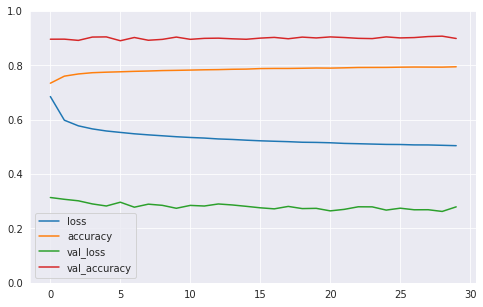

In [47]:
pd.DataFrame(hist4.history).plot(figsize=(8, 5))
sns.set_style('darkgrid')
plt.ylim((0, 1))
plt.savefig('ann-4-learning-curves.png', dpi=300, bbox_inches='tight')
files.download('ann-4-learning-curves.png')
plt.show()

In [48]:
model4.save('sequential4.h5')
files.download('sequential4.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

More features and a larger network lead to improved training and validation accuracy and loss. It's probably time to do some grid-searching to tune the parameters of these networks.

So far, these networks seem to reach their best accuracy around 10-15 epochs of training.